# **Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Library**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# **Load Dataset**

In [3]:
df = pd.read_csv("/content/drive/Othercomputers/My Laptop/SKRIPSI/APLIKASI/heart_2020_cleaned.csv")

In [4]:
df.duplicated().sum()

np.int64(18078)

In [5]:
df = df.drop_duplicates()

In [6]:
df_pos = df[df['HeartDisease'] == 'Yes']
df_neg = df[df['HeartDisease'] == 'No']
n_pos = len(df_pos)
n_neg = min(len(df_neg), 2 * n_pos)
df_neg_under = df_neg.sample(n=n_neg, random_state=42)
df = pd.concat([df_pos, df_neg_under])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Class Distribution:
HeartDisease
No     54522
Yes    27261
Name: count, dtype: int64


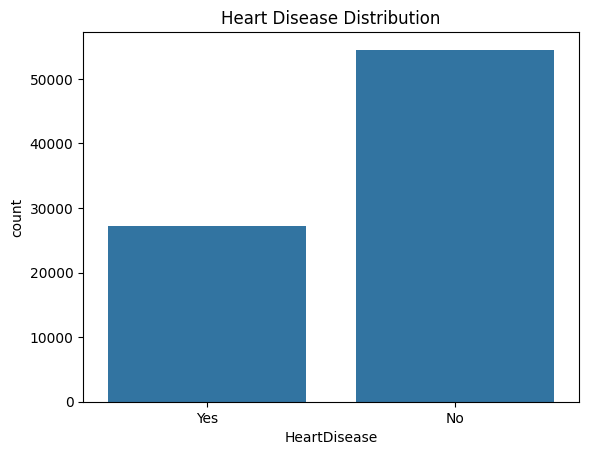

In [7]:
print("Class Distribution:")
print(df['HeartDisease'].value_counts())
sns.countplot(x='HeartDisease', data=df)
plt.title("Heart Disease Distribution")
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

In [9]:
df.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,1,29.05,1,0,0,0.0,0.0,1,0,12,5,0,1,1,7.0,0,0,1
1,1,30.70,0,0,0,5.0,15.0,0,0,8,5,2,1,2,8.0,0,1,0
2,1,25.19,0,0,0,0.0,0.0,0,0,12,5,0,1,2,8.0,0,0,0
3,0,31.09,0,0,0,0.0,0.0,0,0,5,4,0,1,4,6.0,0,0,0
4,0,37.79,0,0,0,0.0,0.0,1,0,12,5,0,0,2,8.0,0,0,0


In [10]:
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    test_size=0.8, stratify=y_train, random_state=42
)

In [ ]:
from scipy.stats import randint

# Contoh parameter grid
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None] + list(np.arange(5, 20)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv_stratified,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_sample, y_sample)
best_params = random_search.best_params_
print("Best Params:", best_params)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Params: {'max_depth': np.int64(18), 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 149}


In [12]:
#Tidak pakai Stratified, Belum buang duplikat, cv=3, pakai sampling 20%
#Best Params: {'max_depth': np.int64(15), 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 157}

#Pakai Stratified, Sudah buang duplikat, cv=5, pakai sampling 20%
#Best Params: {'max_depth': np.int64(18), 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 149}

#iter 40, sampling 70%, cv=5
#Best Params: {'max_depth': np.int64(18), 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 149}

from imblearn.ensemble import BalancedRandomForestClassifier

best_params = {
    'n_estimators': 149,
    'max_depth': 18,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'sqrt'
}

best_model = BalancedRandomForestClassifier(
    **best_params,
    random_state=42
)

best_model.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=18, min_samples_split=5,
                               n_estimators=149, random_state=42)

In [13]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[8079 2826]
 [1189 4263]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.74      0.80     10905
           1       0.60      0.78      0.68      5452

    accuracy                           0.75     16357
   macro avg       0.74      0.76      0.74     16357
weighted avg       0.78      0.75      0.76     16357

ROC AUC Score: 0.8368778179320302


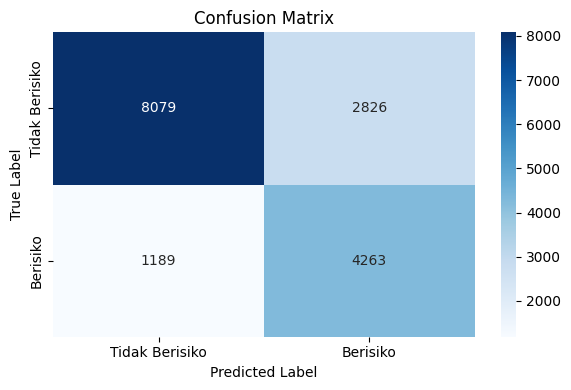

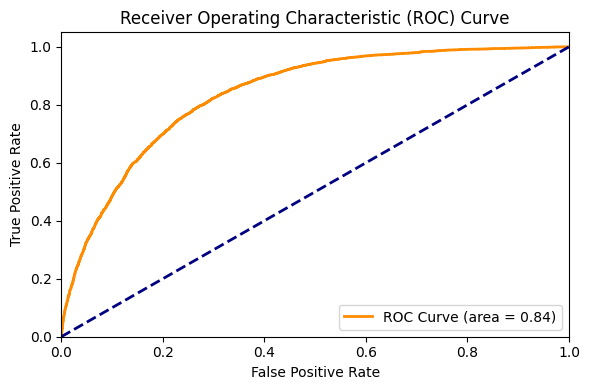

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Prediksi
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak Berisiko', 'Berisiko'], yticklabels=['Tidak Berisiko', 'Berisiko'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# Simpan model ke file 'heart_disease_model.pkl'
with open("BRF-model.pkl", "wb") as file:
    pickle.dump(best_model, file)

print("Model berhasil disimpan ke heart_disease_model.pkl")

Model berhasil disimpan ke heart_disease_model.pkl


In [ ]:
import pickle
import numpy as np

# Load model
with open("BRF-model.pkl", "rb") as f:
    model = pickle.load(f)

# Fungsi prediksi manual
def predict_heart_disease(input_data, threshold=0.47):
    """
    input_data: list atau array dengan urutan fitur sesuai dataset
    threshold: ambang batas probabilitas untuk klasifikasi positif
    """
    # Pastikan input_data bentuknya array 2D: (1, fitur)
    input_array = np.array(input_data).reshape(1, -1)

    # Dapatkan probabilitas prediksi kelas 1 (HeartDisease = Yes)
    proba = model.predict_proba(input_array)[0, 1]

    # Prediksi kelas berdasarkan threshold
    pred = 1 if proba >= threshold else 0

    return pred, proba

# Contoh data input sesuai atribut yang kamu kasih (tanpa kolom 'HeartDisease' karena itu target)
# Urutan fitur: BMI, Smoking, AlcoholDrinking, Stroke, PhysicalHealth, MentalHealth, DiffWalking,
# Sex, AgeCategory, Race, Diabetic, PhysicalActivity, GenHealth, SleepTime, Asthma, KidneyDisease, SkinCancer
data_baru = [
    35.00,  # BMI
    1,      # Smoking
    1,      # AlcoholDrinking
    1,      # Stroke
    10.0,    # PhysicalHealth
    5.0,    # MentalHealth
    1,      # DiffWalking
    0,      # Sex
    11,      # AgeCategory
    2,      # Race
    1,      # Diabetic
    0,      # PhysicalActivity
    1,      # GenHealth
    4.0,   # SleepTime
    1,      # Asthma
    1,      # KidneyDisease
    1       # SkinCancer
]

prediksi, probabilitas = predict_heart_disease(data_baru, threshold=0.47)

print(f"Prediksi HeartDisease: {'Yes' if prediksi == 1 else 'No'}")
print(f"Probabilitas: {probabilitas:.4f}")


Prediksi HeartDisease: Yes
Probabilitas: 0.8322


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BalancedRandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

Training Accuracy: 0.8738
Testing Accuracy: 0.7816
